In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats

In [2]:
rows_to_skip = ['70m_rpev2_log1p_delta_pretrain{True}_freeze{False}',
                '70m_fullseq_pretrain{True}_freeze{True}_gears']

In [3]:
# Filter the data for the updated dataset names
datasets_of_interest = ['Adamson', 'Norman', 'Norman_single', 'RPE1', 'RPE1_V2']
models_of_interest_res_test = ['pretrain{True}_freeze{False}', 'pretrain{False}_freeze{True}', 'linear', 'Null']
models_of_interest_delta_test = ['pretrain{True}_freeze{False}', 'pretrain{False}_freeze{True}', 'gears' ,'linear', 'Null']
models_of_interest_val = ['pretrain{True}_freeze{False}', 'pretrain{False}_freeze{True}', 'null']


In [4]:
df = pd.read_csv("Theta_F_Results - Sheet1.csv")
df = df[~df['run-name'].isin(rows_to_skip)]
# df


In [5]:
df_cleaned = df[df['data-processed-by'].str.startswith('Vevo')]
df_cleaned = df_cleaned[~df_cleaned['run-name'].isin(rows_to_skip)]
df_cleaned = df_cleaned[df_cleaned['Model-input-type']!='bin']
df_cleaned = df_cleaned[df_cleaned['Codebase']!='Far\'s']
df_cleaned.loc[df_cleaned['dataset'].str.startswith('Norman_single'), 'dataset'] = 'Norman_single'
df_cleaned.loc[df_cleaned['data-processed-by'].str.endswith('V2'), 'dataset'] = 'RPE1_V2'
df_cleaned.loc[df_cleaned['Model-config'].str.startswith('linear'), 'Model-config'] = 'linear'
# df_cleaned

In [6]:
# Filter the data for the relevant datasets
filtered_df = df_cleaned[df_cleaned['dataset'].isin(datasets_of_interest)]
# filtered_df

In [7]:
### Test
split = 'test'


# Prepare data for plotting
plot_data_res = {}
plot_data_delta = {}

for dataset in datasets_of_interest:

    # Collect pearson_res values
    plot_data_res[dataset] = []
    for model in models_of_interest_res_test:
        # Filter for the current dataset and model
        model_data = filtered_df[(filtered_df['dataset'] == dataset) & (filtered_df['Model-config'].str.contains(model, case=False))]

        if not model_data.empty:
            pearson_res = model_data[f'pearson_res_{split}'].dropna()
            if not pearson_res.empty:
                plot_data_res[dataset].append(pearson_res.reset_index(drop=True))
            else:
                plot_data_res[dataset].append(None)  # No data, set to None
        else:
            plot_data_res[dataset].append(None)  # No data, set to None

    # Collect pearson_delta values
    plot_data_delta[dataset] = []
    for model in models_of_interest_delta_test:
        # Filter for the current dataset and model
        model_data = filtered_df[(filtered_df['dataset'] == dataset) & (filtered_df['Model-config'].str.contains(model, case=False))]
        if not model_data.empty:
            pearson_delta = model_data[f'pearson_delta_{split}'].dropna()
            if not pearson_delta.empty:
                plot_data_delta[dataset].append(pearson_delta.reset_index(drop=True))
            else:
                plot_data_delta[dataset].append(None)  # No data, set to None
        else:
            plot_data_delta[dataset].append(None)  # No data, set to None

In [8]:
plot_data_res

{'Adamson': [0    0.37
  1    0.30
  Name: pearson_res_test, dtype: float64,
  0    0.2
  Name: pearson_res_test, dtype: float64,
  0   -0.09
  Name: pearson_res_test, dtype: float64,
  0    0.05
  Name: pearson_res_test, dtype: float64],
 'Norman': [0    0.68
  Name: pearson_res_test, dtype: float64,
  0    0.56
  Name: pearson_res_test, dtype: float64,
  0    0.64
  Name: pearson_res_test, dtype: float64,
  0   -0.03
  Name: pearson_res_test, dtype: float64],
 'Norman_single': [0    0.03
  1    0.06
  2    0.27
  Name: pearson_res_test, dtype: float64,
  0    0.07
  1    0.10
  2    0.20
  Name: pearson_res_test, dtype: float64,
  None,
  0    0.10
  1    0.17
  2    0.10
  Name: pearson_res_test, dtype: float64],
 'RPE1': [0    0.12
  Name: pearson_res_test, dtype: float64,
  0    0.1
  Name: pearson_res_test, dtype: float64,
  0   -0.03
  Name: pearson_res_test, dtype: float64,
  0    0.03
  Name: pearson_res_test, dtype: float64],
 'RPE1_V2': [0    0.08
  Name: pearson_res_test, d

/tmp/ipykernel_1063637/666790866.py:84: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


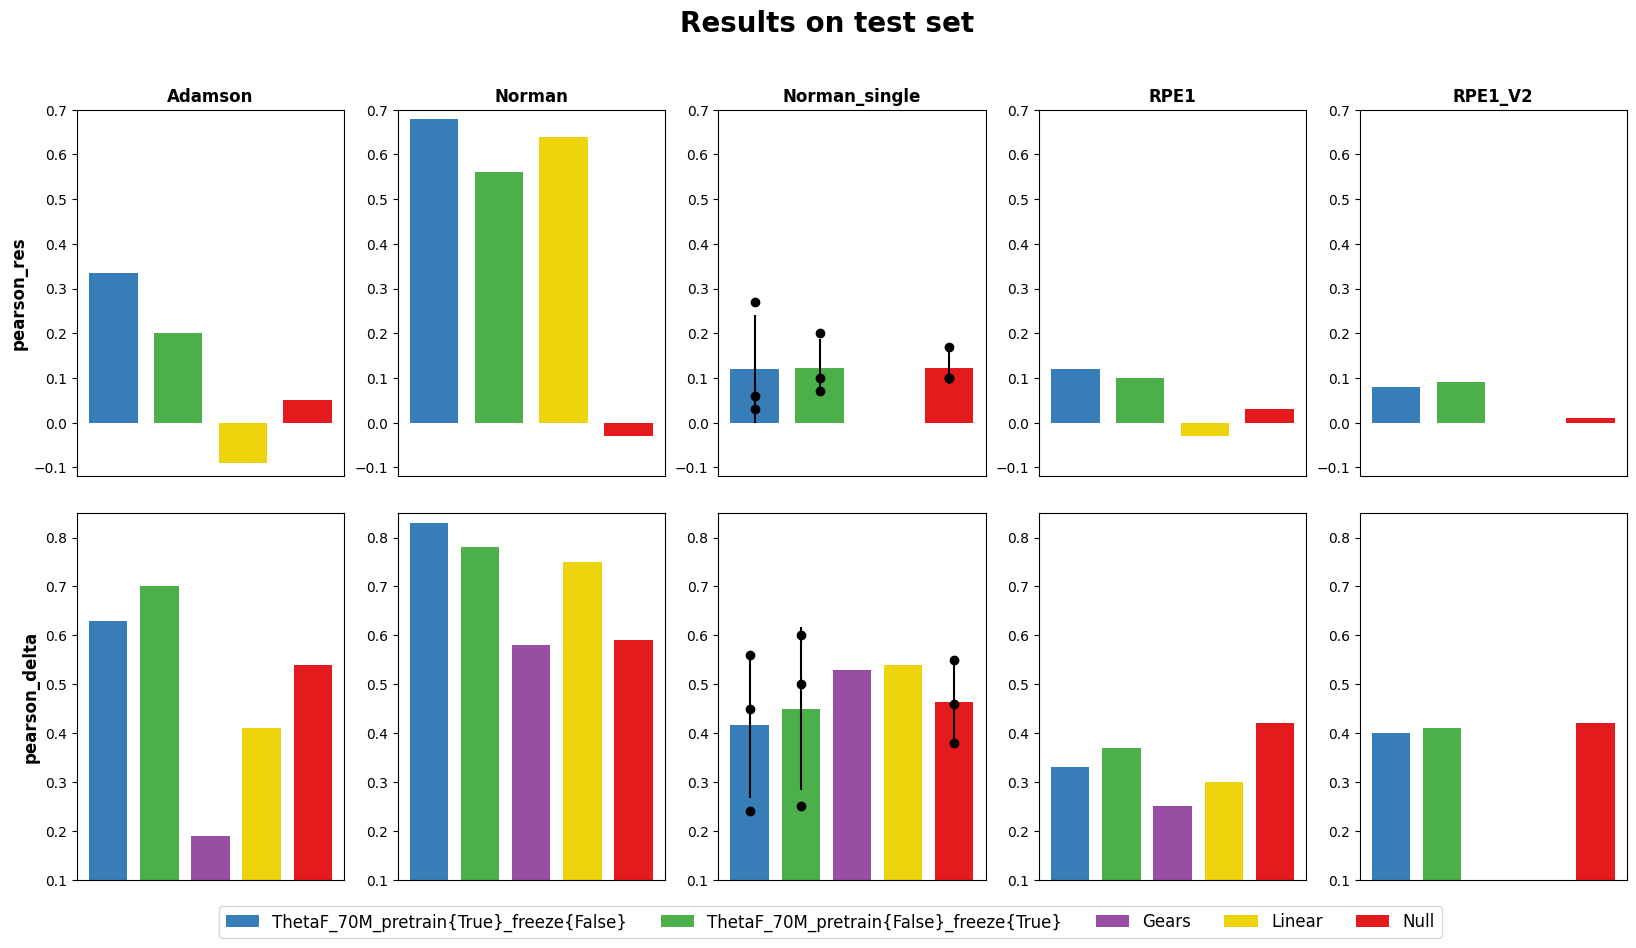

In [40]:
min_res, max_res = -0.12, 0.7
min_delta, max_delta = 0.1, 0.85

# Plot settings
fig, axes = plt.subplots(2, len(datasets_of_interest), figsize=(20, 10), sharey=False)


bar_width = 0.75  # Adjusted bar width for better visibility
x_labels_res = ['ThetaF_70M_pretrain{True}_freeze{False}', 'ThetaF_70M_pretrain{False}_freeze{True}', 'Linear', 'Null']
x_labels_delta = ['ThetaF_70M_pretrain{True}_freeze{False}', 'ThetaF_70M_pretrain{False}_freeze{True}', 'Gears', 'Linear', 'Null']
colors_res = ['#377eb8', '#4daf4a', '#edd30c', '#e41a1c']
colors_delta = ['#377eb8', '#4daf4a', '#984ea3', '#edd30c', '#e41a1c']
capsize_val_org = 5

# Plot each dataset in a separate subplot
metric = f'pearson_res_{split}'
for i, (dataset, ax) in enumerate(zip(datasets_of_interest, axes[0])):
    data = plot_data_res[dataset]
    for j, res_df in enumerate(data):
        if res_df is None:
            continue

        mean_val = res_df.mean()
        ax.bar(j, mean_val, width=bar_width, color=colors_res[j], label=x_labels_res[j] if i == 0 else "")

        # Calculate cofidence interval and plot error bar only for norman_single
        if 'single' in dataset: # type: ignore
            if len(res_df) <= 1:
                continue
            # Compute the confidence interval (95% confidence interval)
            z_critical = 1.96
            std_dev = np.std(res_df)
            margin_of_error = z_critical * (std_dev / np.sqrt(len(res_df)))

            # Plot bar for mean with confidence interval as error bars
            ax.errorbar(j, mean_val, yerr=margin_of_error, color='black')

            for row in res_df:
                ax.scatter(j, row, marker='o', color='black')

    
    ax.set_title(dataset, fontweight='bold')
    ax.set_xticks([])
    ax.set_ylim([min_res, max_res])  # Set the same y-axis limits for all subplots


axes[0,0].set_ylabel('pearson_res', fontweight='bold', fontsize=12)

# Plot each dataset in a separate subplot
for i, (dataset, ax) in enumerate(zip(datasets_of_interest, axes[1])):
    data = plot_data_delta[dataset]

    for j, delta_df in enumerate(data):
        if delta_df is None:
            continue

        mean_val = delta_df.mean()
        ax.bar(j, mean_val, width=bar_width, color=colors_delta[j], label=x_labels_delta[j] if i == 0 else "")

        # Calculate cofidence interval and plot error bar only for norman_single
        if 'single' in dataset: # type: ignore
            if len(delta_df) <= 1:
                continue
            # Compute the confidence interval (95% confidence interval)
            z_critical = 1.96
            std_dev = np.std(delta_df)
            margin_of_error = z_critical * (std_dev / np.sqrt(len(delta_df)))

            # Plot bar for mean with confidence interval as error bars
            ax.errorbar(j, mean_val, yerr=margin_of_error, color='black')

            for row in delta_df:
                ax.scatter(j, row, marker='o', color='black')

    ax.set_xticks([])
    ax.set_ylim([min_delta, max_delta])

axes[1,0].set_ylabel('pearson_delta', fontweight='bold', fontsize=12)

# Add legend
axes[1,0].legend(bbox_to_anchor=(0.5, -0.05), loc='upper left', ncol = 5, fontsize=12)

plt.subplots_adjust(hspace=0.1)
plt.tight_layout()
plt.suptitle(f'Results on {split} set', fontweight='bold', fontsize=20)
plt.savefig(f'results_{split}.png', format='png', dpi=300)  # Save as PNG with 300 dpi
plt.show()

/tmp/ipykernel_1063637/794238412.py:122: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


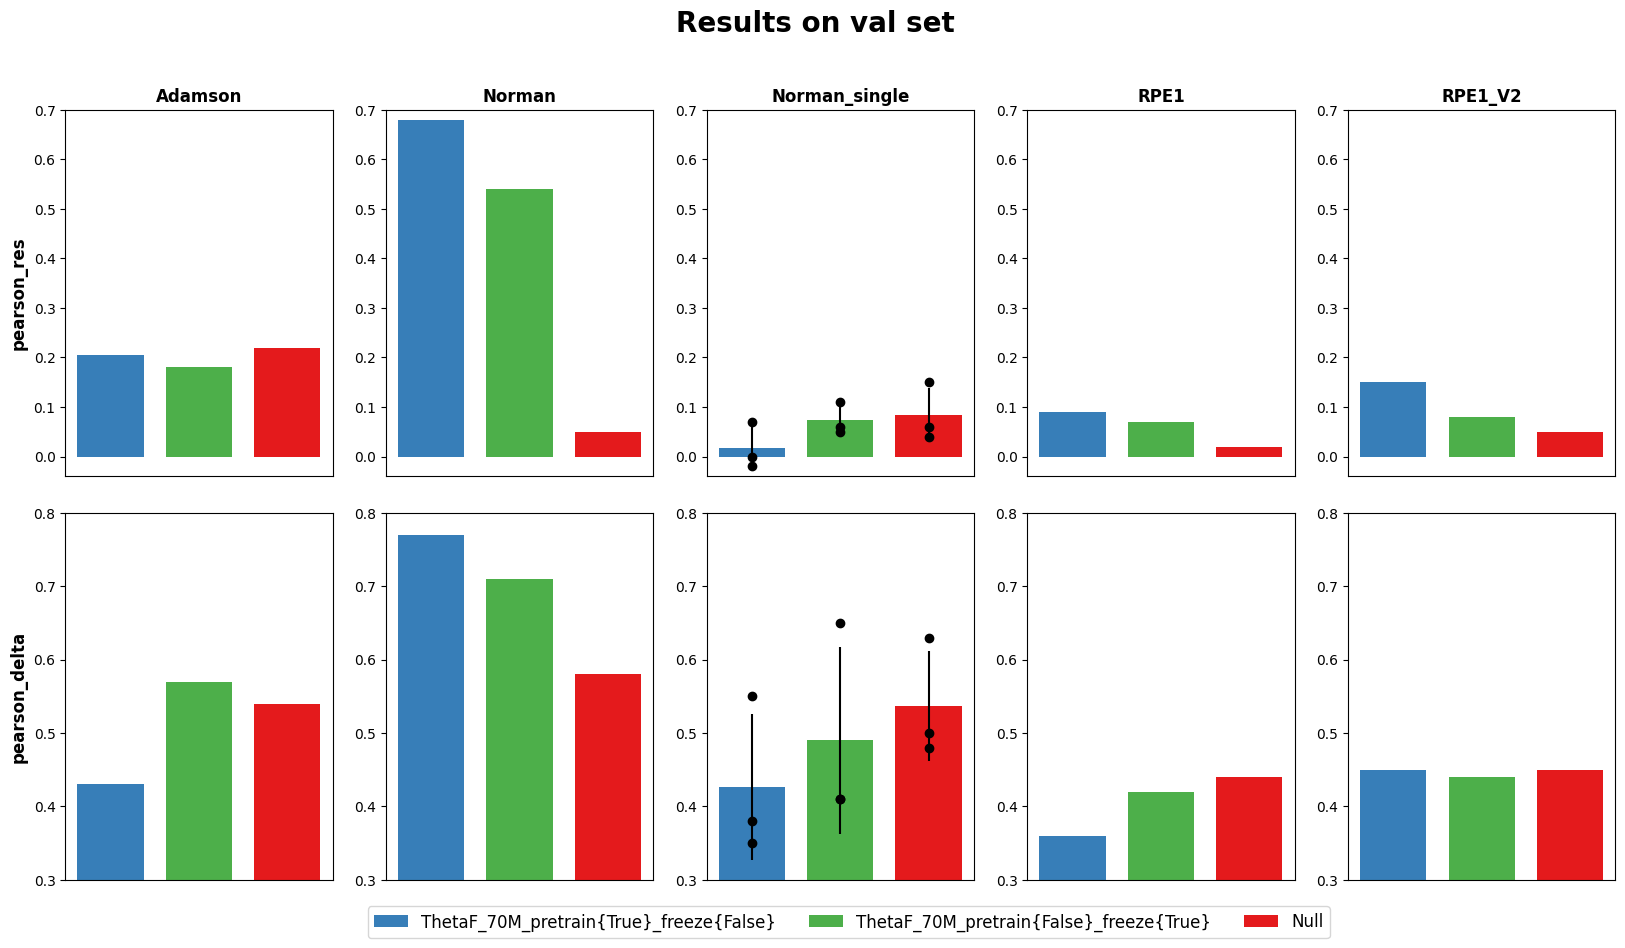

In [45]:
### Test
split = 'val'


# Prepare data for plotting
plot_data_res = {}
plot_data_delta = {}

for dataset in datasets_of_interest:

    # Collect pearson_res values
    plot_data_res[dataset] = []
    for model in models_of_interest_val:
        # Filter for the current dataset and model
        model_data = filtered_df[(filtered_df['dataset'] == dataset) & (filtered_df['Model-config'].str.contains(model, case=False))]
        if not model_data.empty:
            pearson_res = model_data[f'pearson_res_{split}'].dropna()
            if not pearson_res.empty:
                plot_data_res[dataset].append(pearson_res.reset_index(drop=True))
            else:
                plot_data_res[dataset].append(None)  # No data, set to None
        else:
            plot_data_res[dataset].append(None)  # No data, set to None

    # Collect pearson_delta values
    plot_data_delta[dataset] = []
    for model in models_of_interest_val:
        # Filter for the current dataset and model
        model_data = filtered_df[(filtered_df['dataset'] == dataset) & (filtered_df['Model-config'].str.contains(model, case=False))]
        if not model_data.empty:
            pearson_delta = model_data[f'pearson_delta_{split}'].dropna()
            if not pearson_delta.empty:
                plot_data_delta[dataset].append(pearson_delta.reset_index(drop=True))
            else:
                plot_data_delta[dataset].append(None)  # No data, set to None
        else:
            plot_data_delta[dataset].append(None)  # No data, set to None



# Calculate common y-axis limits (min and max)
min_res, max_res = -0.04, 0.7
min_delta, max_delta = 0.3, 0.8

# Plot settings
fig, axes = plt.subplots(2, len(datasets_of_interest), figsize=(20, 10), sharey=False)


bar_width = 0.75  # Adjusted bar width for better visibility
x_labels = ['ThetaF_70M_pretrain{True}_freeze{False}', 'ThetaF_70M_pretrain{False}_freeze{True}', 'Null']
colors = ['#377eb8', '#4daf4a', '#e41a1c']
capsize_val_org = 5

# Plot each dataset in a separate subplot
for i, (dataset, ax) in enumerate(zip(datasets_of_interest, axes[0])):
    data = plot_data_res[dataset]
    for j, res_df in enumerate(data):
        if res_df is None:
            continue

        mean_val = res_df.mean()
        ax.bar(j, mean_val, width=bar_width, color=colors[j], label=x_labels[j] if i == 0 else "")

        # Calculate cofidence interval and plot error bar only for norman_single
        if 'single' in dataset: # type: ignore
            if len(res_df) <= 1:
                continue
            # Compute the confidence interval (95% confidence interval)
            z_critical = 1.96
            std_dev = np.std(res_df)
            margin_of_error = z_critical * (std_dev / np.sqrt(len(res_df)))

            # Plot bar for mean with confidence interval as error bars
            ax.errorbar(j, mean_val, yerr=margin_of_error, color='black')

            for row in res_df:
                ax.scatter(j, row, marker='o', color='black')
    
    ax.set_title(dataset, fontweight='bold')
    ax.set_xticks([])
    ax.set_ylim([min_res, max_res])  # Set the same y-axis limits for all subplots


axes[0,0].set_ylabel('pearson_res', fontweight='bold', fontsize=12)


# Plot each dataset in a separate subplot
for i, (dataset, ax) in enumerate(zip(datasets_of_interest, axes[1])):
    data = plot_data_delta[dataset]
    
    for j, delta_df in enumerate(data):
        if delta_df is None:
            continue

        mean_val = delta_df.mean()
        ax.bar(j, mean_val, width=bar_width, color=colors[j], label=x_labels[j] if i == 0 else "")

        # Calculate cofidence interval and plot error bar only for norman_single
        if 'single' in dataset: # type: ignore
            if len(delta_df) <= 1:
                continue
            # Compute the confidence interval (95% confidence interval)
            z_critical = 1.96
            std_dev = np.std(delta_df)
            margin_of_error = z_critical * (std_dev / np.sqrt(len(delta_df)))

            # Plot bar for mean with confidence interval as error bars
            ax.errorbar(j, mean_val, yerr=margin_of_error, color='black')

            for row in delta_df:
                ax.scatter(j, row, marker='o', color='black')
    ax.set_xticks([])
    # ax.set_xticklabels(x_labels, rotation=45, ha="right")
    ax.set_ylim([min_delta, max_delta])

axes[1,0].set_ylabel('pearson_delta', fontweight='bold', fontsize=12)

# Add legend
axes[1,0].legend(bbox_to_anchor=(1.1, -0.05), loc='upper left', ncol = 5, fontsize=12)

plt.subplots_adjust(hspace=0.1)
plt.tight_layout()
plt.suptitle(f'Results on {split} set', fontweight='bold', fontsize=20)
plt.savefig(f'results_{split}.png', format='png', dpi=300)  # Save as PNG with 300 dpi
plt.show()

In [28]:
# Filter the data for the updated dataset names
datasets_of_interest = ['Adamson', 'Norman']
models_of_interest = ['1.3B', '70M', 'gears', 'linear', 'Null']
configs_of_interest = { '1.3B' : ['pretrain{True}_freeze{False}', 'pretrain{True}_freeze{True}'],
                        '70M' : ['pretrain{True}_freeze{False}', 'pretrain{True}_freeze{True}', 'pretrain{False}_freeze{True}', 'pretrain{False}_freeze{False}']}
metric = 'pearson_delta_test'

In [12]:
df = pd.read_csv("Theta_F_Results - Sheet1.csv")
df_cleaned = df[df['data-processed-by']=='gears']
df_cleaned = df_cleaned[~df_cleaned['run-name'].isin(rows_to_skip)]
df_cleaned = df_cleaned[df_cleaned['dataset'].isin(datasets_of_interest)]
df_cleaned.loc[df_cleaned['Model-config'].str.startswith('linear'), 'Model-config'] = 'linear'
df_cleaned.loc[df_cleaned['Model-size'].str.startswith('linear'), 'Model-size'] = 'linear'

df_cleaned

,run-name,dataset,data-processed-by,Model-size,Model-config,Model-input-type,Codebase,pearson_delta_val,pearson_res_val,pearson_delta_test,pearson_res_test
0,scGPT-1.3B-full-finetune,Adamson,gears,1.3B,pretrain{True}_freeze{False},bin,Haotian's,0.67,NaN,0.60,NaN
1,scGPT-1.3B-freeze-transformer,Adamson,gears,1.3B,pretrain{True}_freeze{True},bin,Haotian's,0.67,NaN,0.62,NaN
2,scGPT-1.3B-freeze-transformer,Adamson,gears,1.3B,pretrain{True}_freeze{True},bin,Haotian's,0.66,NaN,0.62,NaN
3,scGPT-70M-full-finetune,Adamson,gears,70M,pretrain{True}_freeze{False},bin,Haotian's,0.69,NaN,0.63,NaN
4,scGPT-70M-freeze-transformer,Adamson,gears,70M,pretrain{True}_freeze{True},bin,Haotian's,0.70,NaN,0.63,NaN
5,from-scratch-freeze,Adamson,gears,70M,pretrain{False}_freeze{True},bin,Haotian's,0.78,NaN,0.71,NaN
6,from-scratch-freeze,Adamson,gears,70M,pretrain{False}_freeze{True},bin,Haotian's,0.78,NaN,0.70,NaN
7,70m_fullseq_pretrain{True}_freeze{False}_gears,Adamson,gears,70M,pretrain{True}_freeze{False},bin,Far's,0.68,NaN,NaN,NaN
9,70m_fullseq_pretrain{False}_freeze{True}_gears,Adamson,gears,70M,pretrain{False}_freeze{True},bin,Far's,0.74,NaN,0.67,NaN
10,70m_fullseq_pretrain{False}_freeze{False}_gears,Adamson,gears,70M,pretrain{False}_freeze{False},bin,Far's,0.69,NaN,0.66,NaN


In [13]:
filtered_df = df_cleaned[df_cleaned['dataset'].isin(datasets_of_interest)]

In [14]:
split = 'test'


# Prepare data for plotting
plot_data= {}

for dataset in datasets_of_interest:

    # Collect pearson_res values
    plot_data[dataset] = []
    for model in models_of_interest:
        # Filter for the current dataset and model
        model_data = filtered_df[(filtered_df['dataset'] == dataset) & (filtered_df['Model-size'].str.contains(model, case=False))]
        if not model_data.empty:
            pearson_res = model_data[[metric, 'Model-config']].dropna()
            if not pearson_res.empty:
                plot_data[dataset].append(pearson_res.reset_index(drop=True))
            else:
                plot_data[dataset].append(None)  # No data, set to None
        else:
            plot_data[dataset].append(None)  # No data, set to None


/far/miniforge3/envs/perturb/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/far/miniforge3/envs/perturb/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


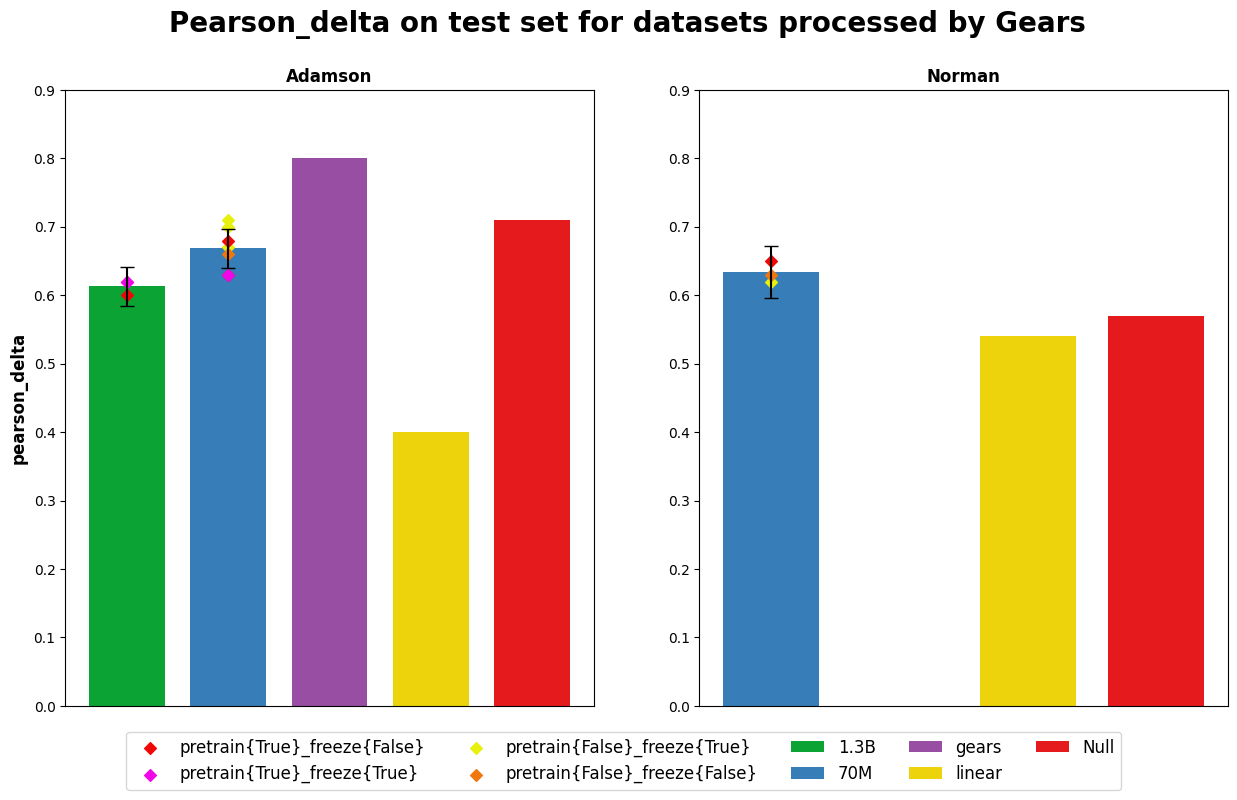

In [15]:
# min_delta, max_delta = 0.3, 0.9 #hard coded for better vis

# # Plot settings
# fig, axes = plt.subplots(1, len(datasets_of_interest), figsize=(15, 8), sharey=False)


# bar_width = 0.75  # Adjusted bar width for better visibility
# x_labels = models_of_interest #['ThetaF_70M_pretrain{True}_freeze{False}', 'ThetaF_70M_pretrain{False}_freeze{True}', 'Null']
# colors = ['#0ba334', '#377eb8', '#984ea3', '#edd30c', '#e41a1c']
# colors_points = {
#     'pretrain{True}_freeze{False}': '#f00707',
#     'pretrain{True}_freeze{True}': '#f007e8',
#     'pretrain{False}_freeze{True}': '#e8f00e',
#     'pretrain{False}_freeze{False}': '#f0770e'
# }
# labels = []
# # Plot each dataset in a separate subplot
# for i, (dataset, ax) in enumerate(zip(datasets_of_interest, axes)):
#     data = plot_data[dataset]
#     for j, delta_df in enumerate(data):
#         if delta_df is None:
#             continue

#         # Calculate mean and confidence interval for the current model's data
#         mean_val = delta_df[metric].mean()
#         conf_interval = stats.sem(delta_df[metric]) * stats.t.ppf((1 + 0.95) / 2., len(delta_df[metric]) - 1)
        
#         ax.bar(j, mean_val, width=bar_width, color=colors[j], label=x_labels[j] )
#         ax.errorbar(j, mean_val, yerr=conf_interval, fmt='-', color='black', capsize=5)

#         if len(delta_df) == 1:
#             continue
        
#         for krow in delta_df.iterrows():
#             k, row = krow
#             lbl = row['Model-config'] if row['Model-config'] not in labels else ''
#             ax.scatter(j, row[metric], color=colors_points[row['Model-config']], marker='D', label = lbl)
#             if row['Model-config'] not in labels:
#                 labels.append(row['Model-config'])
            
#     ax.set_title(dataset, fontweight='bold')
#     ax.set_xticks([])
#     ax.set_ylim([0, max_delta])  # Set the same y-axis limits for all subplots


# axes[0].set_ylabel('pearson_delta', fontweight='bold', fontsize=12)


# # Add legend
# axes[0].legend(bbox_to_anchor=(0.1, -0.15), loc='lower left', ncol = 5, fontsize=12)

# plt.subplots_adjust(hspace=0.1)
# # plt.tight_layout()
# plt.suptitle(f'Pearson_delta on test set for datasets processed by Gears', fontweight='bold', fontsize=20)
# plt.savefig(f'gears_results_{split}.png', format='png', dpi=300)  # Save as PNG with 300 dpi
# plt.show()

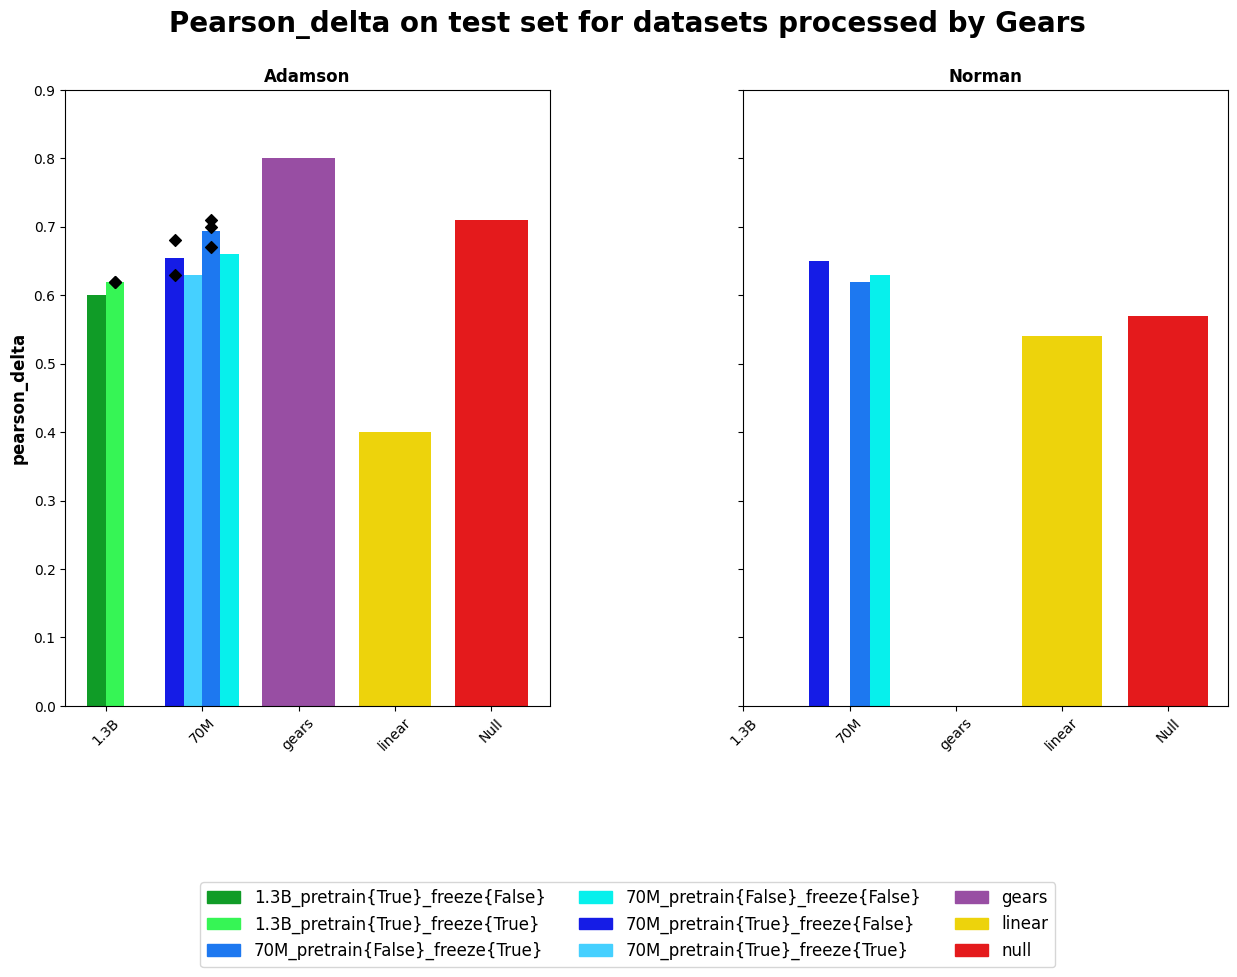

In [49]:
min_delta, max_delta = 0.3, 0.9  # hard-coded for better visualization

# Plot settings
fig, axes = plt.subplots(1, len(datasets_of_interest), figsize=(15, 8), sharey=True)

group_bar_width = 0.19  # Reduced bar width for grouped bars
single_bar_width = 0.75  # Width for gears, null, and linear bars

colors = ['#0ba334', '#377eb8', '#984ea3', '#edd30c', '#e41a1c']
colors_points = { '1.3B': {
    'pretrain{True}_freeze{False}': '#109c27',
    'pretrain{True}_freeze{True}': '#36f555'
    },

    '70M':{
    'pretrain{False}_freeze{True}': '#1d78f0',
    'pretrain{False}_freeze{False}': '#07f0ec',
    'pretrain{True}_freeze{False}': '#151ce6',
    'pretrain{True}_freeze{True}': '#45d0ff'
    }

}


# Prepare the legend labels manually
custom_legend = [
    # 1.3B Model Configs
    (colors_points['1.3B']['pretrain{True}_freeze{False}'], '1.3B_pretrain{True}_freeze{False}'),
    (colors_points['1.3B']['pretrain{True}_freeze{True}'], '1.3B_pretrain{True}_freeze{True}'),
    
    # 70M Model Configs
    (colors_points['70M']['pretrain{False}_freeze{True}'], '70M_pretrain{False}_freeze{True}'),
    (colors_points['70M']['pretrain{False}_freeze{False}'], '70M_pretrain{False}_freeze{False}'),
    (colors_points['70M']['pretrain{True}_freeze{False}'], '70M_pretrain{True}_freeze{False}'),
    (colors_points['70M']['pretrain{True}_freeze{True}'], '70M_pretrain{True}_freeze{True}'),

    # Single models: gears, linear, null (one color each)
    (colors[2], 'gears'),
    (colors[3], 'linear'),
    (colors[4], 'null')
]


# Plot each dataset in a separate subplot
for i, (dataset, ax) in enumerate(zip(datasets_of_interest, axes)):
    data = plot_data[dataset]
    if data is None:
        continue
    num_groups = len(models_of_interest)

    for j, delta_df in enumerate(data):
        if delta_df is None:
            continue

        # Determine if current model is 1.3B or 70M to apply grouping            
        if '1.3B' in models_of_interest[j] or '70M' in models_of_interest[j]:

            num_configs = len(configs_of_interest[models_of_interest[j]])  # Number of configs to group
            # Shift the position of the grouped bars so that they are centered
            base_position = j - (group_bar_width * (num_configs - 1)) / 2  # Center group of bars on the x-tick

            for k, model_config in enumerate(configs_of_interest[models_of_interest[j]]):
                # Filter the data for the current model config
                config_data = delta_df[delta_df['Model-config'] == model_config]
                if config_data.empty:
                    continue

                # Calculate mean and confidence interval for the current model's data
                mean_val = config_data[metric].mean()

                # Position bars with group offset for grouped bar plot
                x_position = base_position + k * group_bar_width
                ax.bar(x_position, mean_val, width=group_bar_width, color=colors_points[models_of_interest[j]][model_config], label=model_config if i == 0 else "")


                # Plot individual points for each model config
                if len(config_data) > 1:
                    for idx, row in config_data.iterrows():
                        ax.scatter(x_position, row[metric], color='black', marker='D')

        else:
            # For gears, null, and linear, plot as single wide bars
            mean_val = delta_df[metric].mean()
            ax.bar(j, mean_val, width=single_bar_width, color=colors[j], label=models_of_interest[j])

    # Set subplot title and x-axis ticks
    ax.set_title(dataset, fontweight='bold')
    ax.set_xticks([r for r in range(num_groups)])  # Set xticks based on number of groups
    ax.set_xticklabels([model for model in models_of_interest], rotation=45)
    ax.set_ylim([0, max_delta])

# Set the y-axis label for the leftmost subplot
axes[0].set_ylabel('pearson_delta', fontweight='bold', fontsize=12)

# Manually create legend based on the custom_legend
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color, _ in custom_legend]
legend_labels = [label for _, label in custom_legend]
fig.legend(legend_handles, legend_labels, bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=3, fontsize=12)

plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.suptitle(f'Pearson_delta on test set for datasets processed by Gears', fontweight='bold', fontsize=20)
plt.savefig(f'gears_results_{split}.png', format='png', dpi=300)  # Save as PNG with 300 dpi
plt.show()